# 🇩🇪 German Train Timetable — Data Tutorial (All in One)

Welcome! This notebook loads a synthetic **German train timetable** and walks you through analysis, visualizations, and a simple selection-based lookup — all in one place.

**What you’ll do**
1. Load the CSV and **verify data quality** (no NaNs).
2. Parse times and compute **trip duration**.
3. Analyze: frequency by **day**, average **duration by service**, busiest **stations**.
4. Visualize: bar charts and a **day × hour heatmap**.
5. Use ready-made **helper functions** (commented examples included).
6. Try a **selection-based lookup** to view trains for a chosen origin/destination/day/time.

**Files in this project**
- `german_train_timetable.csv`  — dataset (300 rows, no blanks)
- `requirements.txt`            — install deps (`pandas`, `matplotlib`)
- `LICENSE`                     — MIT license
- `README.md`                   — how to run everything


## 0) Setup
Install requirements in a terminal (once):
```bash
pip install -r requirements.txt
```
Then open this notebook in Jupyter/Lab/VS Code and run cells top to bottom.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Display options (for readability)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', 80)


## 1) Load the CSV

In [14]:
PATH = 'german_train_timetable.csv'  # adjust if needed
df = pd.read_csv(PATH)
df.head()

,id,train_no,service,operator,origin,destination,day,depart_time,arrive_time,platform,stops,notes
0,1,ICE887,ICE,Deutsche Bahn,Hannover Hbf,Hamburg Hbf,Thu,13:00,17:34,15,Dortmund Hbf;Karlsruhe Hbf,Bistro
1,2,ICE445,ICE,Deutsche Bahn,Stuttgart Hbf,Frankfurt(Main)Hbf,Fri,15:50,17:52,3,Essen Hbf;Hamburg Hbf,Seasonal
2,3,IC423,IC,Deutsche Bahn,Hamburg Hbf,Berlin Hbf,Sat,19:00,20:52,2,Dresden Hbf;München Hbf;Bremen Hbf,Peak service
3,4,RE580,RE,Deutsche Bahn,Essen Hbf,Hannover Hbf,Sun,06:20,08:17,9,Dresden Hbf;Kiel Hbf;Bremen Hbf;Berlin Hbf;Rostock Hbf,Limited stops
4,5,RE801,RE,Deutsche Bahn,Mannheim Hbf,Freiburg (Breisgau) Hbf,Fri,20:40,22:57,6,Stuttgart Hbf;Hamburg Hbf,Peak service


### Data quality checks (no NaNs, no empty strings)
- `DataFrame.isna()` counts missing values (NaN).
- `eq('')` finds empty strings. We expect **all zeros**.

In [3]:
# Count NaNs per column
nan_counts = df.isna().sum()
print('NaN counts per column:\n', nan_counts)

# Count empty strings per column
empty_counts = (df.applymap(lambda x: isinstance(x,str) and x.strip()==''))\
                 .sum()
print('\nEmpty-string counts per column:\n', empty_counts)

NaN counts per column:
 id             0
train_no       0
service        0
operator       0
origin         0
              ..
depart_time    0
arrive_time    0
platform       0
stops          0
notes          0
Length: 12, dtype: int64

Empty-string counts per column:
 id             0
train_no       0
service        0
operator       0
origin         0
              ..
depart_time    0
arrive_time    0
platform       0
stops          0
notes          0
Length: 12, dtype: int64


/var/folders/v8/rk468gsd2gv20tfywf40d1wr0000gn/T/ipykernel_1628/3156375798.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  empty_counts = (df.applymap(lambda x: isinstance(x,str) and x.strip()==''))\


## 2) Helper functions (with explanations)
Each function has a docstring and **commented examples** you can try by uncommenting.

In [4]:
def parse_hhmm_to_minutes(s: str) -> int:
    """Convert 'HH:MM' to minutes after midnight.
    Why: Numeric minutes make it easy to sort times and compute durations.
    
    # Example:
    # parse_hhmm_to_minutes('06:30')  # -> 390
    """
    h, m = map(int, str(s).split(':'))
    return h*60 + m

def add_parsed_time_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Add numeric time columns and trip duration in minutes.
    Adds: `depart_min`, `arrive_min`, `duration_min`, and `depart_hour`.
    
    # Example:
    # df2 = add_parsed_time_columns(df)
    # df2[['depart_time','arrive_time','duration_min']].head()
    """
    out = df.copy()
    out['depart_min'] = out['depart_time'].apply(parse_hhmm_to_minutes)
    out['arrive_min'] = out['arrive_time'].apply(parse_hhmm_to_minutes)
    out['duration_min'] = (out['arrive_min'] - out['depart_min']).clip(lower=10)
    out['depart_hour'] = (out['depart_min'] // 60).astype(int)
    return out

def frequency_by_day(df: pd.DataFrame) -> pd.Series:
    """Count trains per day (Mon–Sun) using value_counts.
    Why: See which days are busiest.
    
    # Example:
    # frequency_by_day(df)
    """
    return df['day'].value_counts().sort_index()

def avg_duration_by_service(df: pd.DataFrame) -> pd.Series:
    """Average trip duration by `service` using groupby-mean.
    Why: Compare typical journey time across ICE/IC/RE.
    
    # Example:
    # df2 = add_parsed_time_columns(df)
    # avg_duration_by_service(df2)
    """
    return df.groupby('service')['duration_min'].mean().sort_values()

def busiest_stations(df: pd.DataFrame, top_n: int = 10) -> pd.Series:
    """Find the busiest stations by counting occurrences as origin/destination.
    Why: Identify major hubs.
    
    # Example:
    # busiest_stations(df2, top_n=10)
    """
    counts = df['origin'].value_counts() + df['destination'].value_counts()
    counts = counts.sort_values(ascending=False).head(top_n)
    return counts

def filter_trains(df: pd.DataFrame, origin: str = None, destination: str = None,
                  day: str = None, after: str = None) -> pd.DataFrame:
    """Return trains matching optional filters: origin, destination, day, and after time.
    Why: Simple selection-based lookup directly in the notebook.
    
    # Example:
    # filter_trains(df2, origin='Berlin Hbf', destination='München Hbf', day='Mon', after='08:00')
    """
    out = df.copy()
    if origin:
        out = out[out['origin'] == origin]
    if destination:
        out = out[out['destination'] == destination]
    if day:
        out = out[out['day'].str.lower() == day.lower()]
    if after:
        threshold = parse_hhmm_to_minutes(after)
        out = out[out['depart_min'] >= threshold]
    return out.sort_values(['day','depart_min'])


## 3) Prepare data (parse times & compute duration)

In [5]:
df2 = add_parsed_time_columns(df)
df2.head()

,id,train_no,service,operator,origin,destination,day,depart_time,arrive_time,platform,stops,notes,depart_min,arrive_min,duration_min,depart_hour
0,1,ICE887,ICE,Deutsche Bahn,Hannover Hbf,Hamburg Hbf,Thu,13:00,17:34,15,Dortmund Hbf;Karlsruhe Hbf,Bistro,780,1054,274,13
1,2,ICE445,ICE,Deutsche Bahn,Stuttgart Hbf,Frankfurt(Main)Hbf,Fri,15:50,17:52,3,Essen Hbf;Hamburg Hbf,Seasonal,950,1072,122,15
2,3,IC423,IC,Deutsche Bahn,Hamburg Hbf,Berlin Hbf,Sat,19:00,20:52,2,Dresden Hbf;München Hbf;Bremen Hbf,Peak service,1140,1252,112,19
3,4,RE580,RE,Deutsche Bahn,Essen Hbf,Hannover Hbf,Sun,06:20,08:17,9,Dresden Hbf;Kiel Hbf;Bremen Hbf;Berlin Hbf;Rostock Hbf,Limited stops,380,497,117,6
4,5,RE801,RE,Deutsche Bahn,Mannheim Hbf,Freiburg (Breisgau) Hbf,Fri,20:40,22:57,6,Stuttgart Hbf;Hamburg Hbf,Peak service,1240,1377,137,20


## 4) Analyses

### A) Train frequency by day

In [6]:
freq_day = frequency_by_day(df2)
freq_day

day
Fri    40
Mon    45
Sat    47
Sun    41
Thu    37
Tue    53
Wed    37
Name: count, dtype: int64

### B) Average duration by service

In [7]:
avg_dur = avg_duration_by_service(df2)
avg_dur

service
RE     102.804124
ICE    165.147368
IC     175.296296
Name: duration_min, dtype: float64

### C) Busiest stations

In [8]:
busiest = busiest_stations(df2, top_n=10)
busiest

Augsburg Hbf          38
Hamburg Hbf           35
Rostock Hbf           34
Nürnberg Hbf          34
München Hbf           33
Stuttgart Hbf         33
Hannover Hbf          33
Düsseldorf Hbf        33
Leipzig Hbf           32
Frankfurt(Main)Hbf    32
Name: count, dtype: int64

## 5) Visualizations
Each plot uses **matplotlib** (no custom styles/colors) and one chart per cell.

### Plot: Trains per day

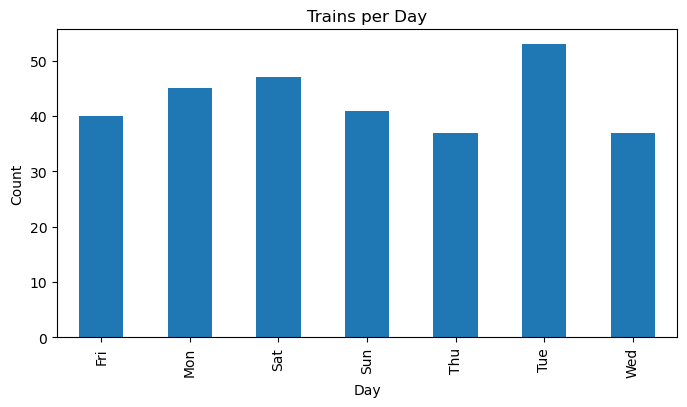

In [9]:
freq_day.plot(kind='bar', figsize=(8,4))
plt.title('Trains per Day')
plt.xlabel('Day')
plt.ylabel('Count')
plt.show()

### Plot: Average duration by service (minutes)

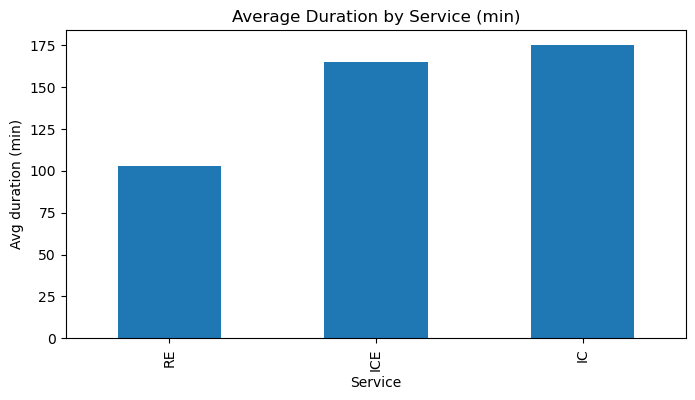

In [10]:
avg_dur.plot(kind='bar', figsize=(8,4))
plt.title('Average Duration by Service (min)')
plt.xlabel('Service')
plt.ylabel('Avg duration (min)')
plt.show()

### Plot: Busiest stations

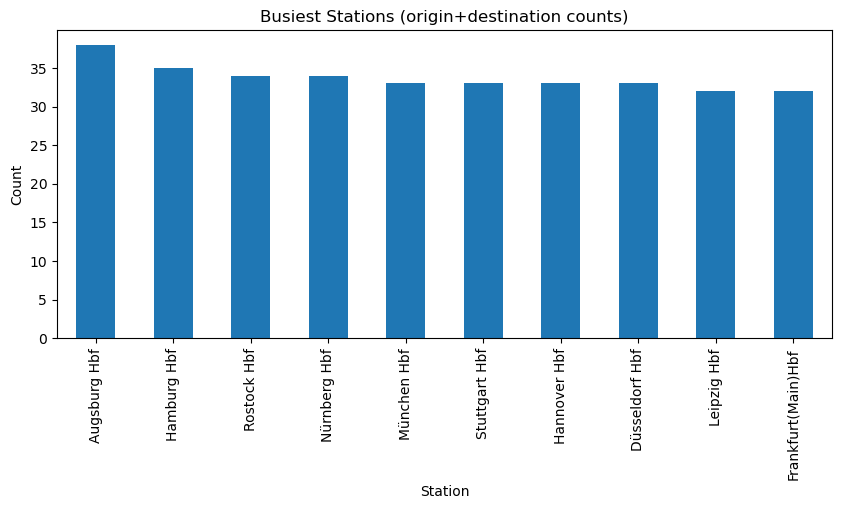

In [11]:
busiest.plot(kind='bar', figsize=(10,4))
plt.title('Busiest Stations (origin+destination counts)')
plt.xlabel('Station')
plt.ylabel('Count')
plt.show()

### Heatmap: Day × Hour departures
We create a pivot of counts by **day** (rows) and **depart_hour** (columns), then draw it with `imshow`.

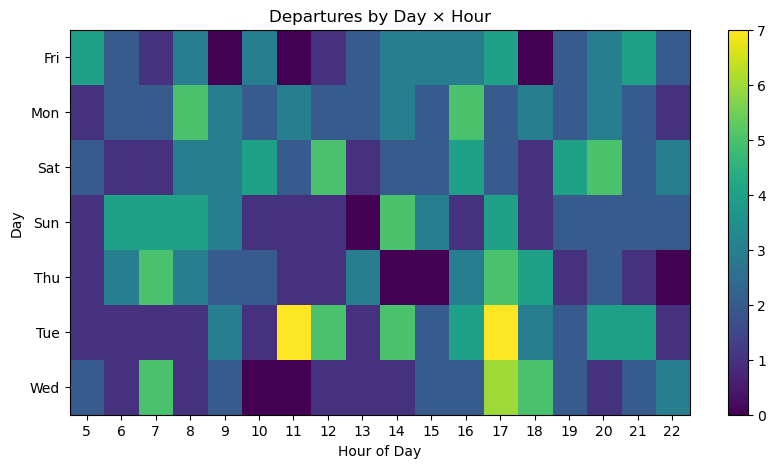

In [12]:
pivot = df2.pivot_table(index='day', columns='depart_hour', values='id', aggfunc='count', fill_value=0)
plt.figure(figsize=(10,5))
plt.imshow(pivot.values, aspect='auto')
plt.title('Departures by Day × Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day')
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.colorbar()
plt.show()

## 6) Selection-based lookup (Notebook "mini app")
Set the variables below and run the cell to view matching trains. Leave any as `None` to skip that filter.
- `origin_sel` — exact station name (e.g., `Berlin Hbf`)
- `destination_sel` — exact station name (e.g., `München Hbf`)
- `day_sel` — one of `Mon..Sun`
- `after_sel` — `HH:MM` to show departures after that time

In [13]:
origin_sel = None          # e.g., 'Berlin Hbf'
destination_sel = None     # e.g., 'München Hbf'
day_sel = None             # e.g., 'Mon'
after_sel = None           # e.g., '08:00'

results = filter_trains(df2, origin=origin_sel, destination=destination_sel, day=day_sel, after=after_sel)
results.head(20)

,id,train_no,service,operator,origin,destination,day,depart_time,arrive_time,platform,stops,notes,depart_min,arrive_min,duration_min,depart_hour
114,115,RE957,RE,Deutsche Bahn,Augsburg Hbf,Rostock Hbf,Fri,05:00,05:53,4,Essen Hbf;Mannheim Hbf;Bremen Hbf;Hamburg Hbf;Kiel Hbf,Peak service,300,353,53,5
218,219,ICE287,ICE,Deutsche Bahn,Stuttgart Hbf,Karlsruhe Hbf,Fri,05:00,06:13,8,Nürnberg Hbf;Rostock Hbf,On time,300,373,73,5
35,36,ICE228,ICE,Deutsche Bahn,Nürnberg Hbf,Leipzig Hbf,Fri,05:40,10:29,13,Essen Hbf;Freiburg (Breisgau) Hbf;Kiel Hbf;Karlsruhe Hbf,Wi-Fi,340,629,289,5
59,60,ICE231,ICE,Deutsche Bahn,Köln Hbf,Augsburg Hbf,Fri,05:40,08:44,9,Freiburg (Breisgau) Hbf;Mannheim Hbf;Hamburg Hbf;Rostock Hbf;Frankfurt(Main)Hbf,Wi-Fi,340,524,184,5
143,144,IC378,IC,Deutsche Bahn,Frankfurt(Main)Hbf,Karlsruhe Hbf,Fri,06:00,08:32,4,München Hbf;Hannover Hbf;Stuttgart Hbf;Leipzig Hbf;Bremen Hbf,Construction detour,360,512,152,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,291,RE799,RE,Deutsche Bahn,Hamburg Hbf,Berlin Hbf,Fri,13:40,15:29,8,Leipzig Hbf;München Hbf,Bistro,820,929,109,13
182,183,IC833,IC,Deutsche Bahn,München Hbf,Düsseldorf Hbf,Fri,14:00,16:41,6,Essen Hbf;Hannover Hbf,Limited stops,840,1001,161,14
11,12,RE496,RE,Deutsche Bahn,München Hbf,Mannheim Hbf,Fri,14:10,15:54,13,Karlsruhe Hbf;Stuttgart Hbf;Bremen Hbf;Nürnberg Hbf;Hamburg Hbf,Construction detour,850,954,104,14
90,91,IC553,IC,Deutsche Bahn,Freiburg (Breisgau) Hbf,Leipzig Hbf,Fri,14:10,18:29,5,Nürnberg Hbf;Augsburg Hbf;Karlsruhe Hbf;Rostock Hbf;Düsseldorf Hbf,Bistro,850,1109,259,14


In [17]:
# === FULL In-Notebook GUI (ipywidgets) for Train Lookup ===
# Works standalone: loads CSV if df not already loaded; defines helpers; builds UI.
# Requires: pandas, ipywidgets (pip install ipywidgets)

import pandas as pd
from ipywidgets import Dropdown, Text, Button, HBox, VBox, HTML, Output
from IPython.display import display
import os

# -----------------------------
# Load data (if not already loaded as df)
# -----------------------------
if "df" not in globals():
    PATH = "german_train_timetable.csv"
    if not os.path.exists(PATH):
        raise FileNotFoundError(
            f"Cannot find {PATH}. Place the CSV next to your notebook or update PATH."
        )
    df = pd.read_csv(PATH)

# -----------------------------
# Helper functions (same as tutorial)
# -----------------------------
def parse_hhmm_to_minutes(s: str) -> int:
    """Convert 'HH:MM' to minutes after midnight."""
    h, m = map(int, str(s).strip().split(":"))
    return h * 60 + m

def add_parsed_time_columns(df_: pd.DataFrame) -> pd.DataFrame:
    """Add numeric time columns and duration."""
    out = df_.copy()
    out["depart_min"] = out["depart_time"].apply(parse_hhmm_to_minutes)
    out["arrive_min"] = out["arrive_time"].apply(parse_hhmm_to_minutes)
    # clip lower bound in case of synthetic edge cases
    out["duration_min"] = (out["arrive_min"] - out["depart_min"]).clip(lower=10)
    out["depart_hour"] = (out["depart_min"] // 60).astype(int)
    return out

def filter_trains(
    df_: pd.DataFrame, origin=None, destination=None, day=None, after=None
) -> pd.DataFrame:
    """Filter trains by origin, destination, day, and optional 'after' HH:MM."""
    out = df_.copy()
    if origin:
        out = out[out["origin"] == origin]
    if destination:
        out = out[out["destination"] == destination]
    if day:
        out = out[out["day"].str.lower() == str(day).lower()]
    if after:
        thr = parse_hhmm_to_minutes(after)
        out = out[out["depart_min"] >= thr]
    return out.sort_values(["day", "depart_min"])

# Prepare augmented frame
df2 = add_parsed_time_columns(df)

# -----------------------------
# Widgets
# -----------------------------
origin_dd = Dropdown(
    options=[""] + sorted(df2["origin"].unique().tolist()),
    description="Origin:",
    layout={"width": "350px"},
)
dest_dd = Dropdown(
    options=[""] + sorted(df2["destination"].unique().tolist()),
    description="Destination:",
    layout={"width": "350px"},
)
day_dd = Dropdown(
    options=[""] + sorted(df2["day"].unique().tolist()),
    description="Day:",
    layout={"width": "200px"},
)
after_txt = Text(
    value="",
    placeholder="HH:MM (optional)",
    description="After:",
    layout={"width": "220px"},
)

run_btn = Button(description="Search", button_style="primary")
clear_btn = Button(description="Clear filters")
status = HTML("<b>Ready.</b>")

# Outputs
results_out = Output()
details_out = Output()

# Table columns to display
LIST_COLUMNS = [
    "train_no",
    "service",
    "origin",
    "destination",
    "day",
    "depart_time",
    "arrive_time",
    "platform",
    "notes",
]

# State
_last_results = pd.DataFrame()

# A dropdown to pick a single train from results for details
train_pick = Dropdown(
    options=[], description="Train:", layout={"width": "650px"}
)

# -----------------------------
# Rendering helpers
# -----------------------------
def _format_train_option(row):
    # e.g. "ICE123 | Berlin Hbf → München Hbf | Mon 08:30–12:05 (P:7)"
    return f"{row['train_no']} | {row['origin']} → {row['destination']} | {row['day']} {row['depart_time']}–{row['arrive_time']} (P:{row['platform']})"

def _update_train_picker(df_):
    if df_.empty:
        train_pick.options = []
        train_pick.value = None
        return
    opts = [(_format_train_option(r), i) for i, r in df_.reset_index(drop=True).iterrows()]
    train_pick.options = opts
    train_pick.value = opts[0][1]  # select first row

def _render_table(df_):
    with results_out:
        results_out.clear_output(wait=True)
        display(df_.reset_index(drop=True))

def _render_details(row):
    # duration
    try:
        dur_min = int(
            row.get(
                "duration_min",
                parse_hhmm_to_minutes(row["arrive_time"])
                - parse_hhmm_to_minutes(row["depart_time"]),
            )
        )
    except Exception:
        dur_min = None
    dur_txt = f"{dur_min} min" if dur_min is not None else "—"

    # stops
    stops_raw = str(row.get("stops", "") or "")
    stops_list = [s.strip() for s in stops_raw.split(";")] if stops_raw else []
    stops_html = " • ".join(stops_list) if stops_list else "Direct / not listed"

    html = f"""
    <div style="font-family: system-ui; border: 1px solid #ddd; border-radius: 10px; padding: 12px; line-height: 1.5;">
      <div style="font-size: 18px; font-weight: 700; margin-bottom: 6px;">
        {row['train_no']} — {row['service']} ({row['operator']})
      </div>
      <div><b>Route:</b> {row['origin']} → {row['destination']}</div>
      <div><b>Day & Time:</b> {row['day']} {row['depart_time']} → {row['arrive_time']} <span style="opacity:0.8;">(≈ {dur_txt})</span></div>
      <div><b>Platform:</b> {row['platform']}</div>
      <div><b>Stops:</b> {stops_html}</div>
      <div><b>Notes:</b> {row.get('notes','')}</div>
      <div style="margin-top:6px; opacity:0.7;">ID: {row['id']}</div>
    </div>
    """
    with details_out:
        details_out.clear_output(wait=True)
        display(HTML(html))

def _on_train_pick_change(change):
    if change.get("name") != "value" or change.get("new") is None:
        return
    idx = int(change["new"])
    row = _last_results.reset_index(drop=True).iloc[idx]
    _render_details(row)

train_pick.observe(_on_train_pick_change, names="value")

# -----------------------------
# Actions
# -----------------------------
def run_search(_=None):
    global _last_results
    origin = origin_dd.value or None
    dest = dest_dd.value or None
    day = day_dd.value or None
    after = (after_txt.value or "").strip() or None

    # Basic validation for time format if provided
    if after and (len(after) != 5 or after[2] != ":" or not after.replace(":", "").isdigit()):
        status.value = "<b style='color:red'>After time must be HH:MM (e.g., 08:30)</b>"
        return

    try:
        results = filter_trains(df2, origin=origin, destination=dest, day=day, after=after)
        _last_results = results.copy()
        status.value = f"<b>Found {len(results)} trains.</b>"

        # Render table (first 100 rows to keep it snappy)
        _render_table(results[LIST_COLUMNS].head(100))

        # Update picker and render details for first row
        _update_train_picker(results)
        if not results.empty:
            _render_details(results.iloc[0])
        else:
            with details_out:
                details_out.clear_output()
    except Exception as e:
        status.value = f"<b style='color:red'>Error:</b> {e}"

def clear_filters(_=None):
    origin_dd.value = ""
    dest_dd.value = ""
    day_dd.value = ""
    after_txt.value = ""
    status.value = "<b>Filters cleared. Ready.</b>"
    with results_out:
        results_out.clear_output()
    with details_out:
        details_out.clear_output()
    train_pick.options = []
    train_pick.value = None

run_btn.on_click(run_search)
clear_btn.on_click(clear_filters)

# -----------------------------
# Export buttons
# -----------------------------
export_csv_btn = Button(description="💾 Export CSV", button_style="success")
export_xlsx_btn = Button(description="⬇️ Export Excel", button_style="success")
export_status = HTML("")

def export_csv(_=None):
    global _last_results
    if _last_results.empty:
        export_status.value = "<b style='color:red'>No results to export.</b>"
        return
    path = "filtered_trains.csv"
    _last_results.to_csv(path, index=False)
    export_status.value = f"<b>Exported {len(_last_results)} rows → {path}</b>"

def export_xlsx(_=None):
    global _last_results
    if _last_results.empty:
        export_status.value = "<b style='color:red'>No results to export.</b>"
        return
    path = "filtered_trains.xlsx"
    _last_results.to_excel(path, index=False)
    export_status.value = f"<b>Exported {len(_last_results)} rows → {path}</b>"

export_csv_btn.on_click(export_csv)
export_xlsx_btn.on_click(export_xlsx)

# -----------------------------
# Layout & Display
# -----------------------------
ui = VBox(
    [
        HBox([origin_dd, dest_dd]),
        HBox([day_dd, after_txt]),
        HBox([run_btn, clear_btn]),
        status,
        train_pick,
        results_out,
        details_out,
        HBox([export_csv_btn, export_xlsx_btn]),
        export_status,
    ]
)

display(ui)

# Optionally auto-run a blank search to populate widgets:
# run_search()
